<a href="https://colab.research.google.com/github/yasminghd/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/S5_1_NNs_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Chapter 10 – Introduction to Neural Networks with Keras**

<center>
<img width=100% src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EWzvoN-LqmBDtvuEXvi3m2MBRr4ACElB77IAfndUaDFVJQ?download=1'><br> Photo Credits: <a href="https://unsplash.com/photos/_HRi5kBwGh0">Galaxy's Edge</a> by <a href="https://unsplash.com/@rodlong">Rod Long</a> licensed under the <a href='https://unsplash.com/license'>Unsplash License</a> 

> *The defnition of AI is a highly contested concept. It often refers to technologies that demonstrate levels of independent intelligence from humans. By its very
defnition, it is an intelligence that is differentiated from natural intelligence; it is
a constructed, artificial, or machine intelligence.* <br>
$\quad$Ryan, M. (2020). In AI we trust: ethics, artificial intelligence, and reliability. Science and Engineering Ethics, 26(5), 2749-2767.

This notebook will be used in the lab session for week 5 of the course, covers Chapters 10 of Géron, and builds on the [notebooks made available on _Github_](https://github.com/ageron/handson-ml2).

Need a reminder of last week's labs? Click [_here_](https://colab.research.google.com/github/tbeucler/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/Week_4_Dimensionality_Reduction_Clustering.ipynb) to go to notebook for week 4 of the course.

## Notebook Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [57]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Initialize the run_index
run_index = None

# Loading Tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Data Setup

Today, we'll once again be working on the MNIST handwritten digit database - we're becoming experts in typography! ✍  

Let's begin by importing the dataset from the keras dataset library.

### **Q1) Load the MNIST dataset from Keras. Divide it into a training, validation, and test dataset**

*Hint 1: To access the Keras library, you can either reimport keras (e.g., `import tensorflow.keras as keras`), or you can access it from the instance of tensorflow we imported during setup (i.e., using `tf.keras`)*

*Hint 2: [Here is the documentation](https://keras.io/api/datasets/mnist/) for the Keras implementation of the MNIST dataset*

*Hint 3: If you use the `mnist.load_data()` method, what will be returned will be a set of tuples: (training_data, testing_data), where training_data and testing_data are tuples of inputs and labels (X, y)*

*Hint 4: You can break down the training dataset from the `.load()` method into a training and validation dataset. Since the full training dataset includes 60 000 samples, try using 50 000 samples as training data and 10 000 samples as validation data.*

In [58]:
import tensorflow.keras as keras
# Load the keras dataset data
( (X_train_full, y_train_full) , (X_test_full, y_test_full) ) = keras.datasets.mnist.load_data()

In [59]:
from sklearn.model_selection import train_test_split
# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=1/6)
#X_valid = X_train_full
X_test = X_test_full
y_test = y_test_full

What does our data look like? Let's get an idea of the values and figure out what kind of preprocessing we should do before training our neural network.

### **Q2) Print the shape of the training, validation, and test sets. Then, print the maximum and minimum input values.**


*Hint 1: You loaded the data as numpy arrays. Thus, you can rely on the built-in methods for finding the shape and min/max values.*

*Hint 2: Click for the documentation on [`ndarray.max()`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.max.html), [`ndarray.min()`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.min.html), and [`ndarray.shape`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html)*

In [60]:
#Write your code here
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)
print(X_train.max(), X_valid.max(), X_test.max())
print(y_train.max(), y_valid.max(), y_test.max())
print(X_train.min(), X_valid.min(), X_test.min())
print(y_train.min(), y_valid.min(), y_test.min())

(50000, 28, 28) (10000, 28, 28) (10000, 28, 28)
(50000,) (10000,) (10000,)
255 255 255
9 9 9
0 0 0
0 0 0


If you used the same train/validation split as we did, you should have 50k samples in the training set, 10k in the validation set, and 10k in the test set. 

Since the data represents grayscale image values, data values should vary between 0 and 255; Normalize the data by dividing it by 255.
### **Q3) Normalize the input data for the training, validation, and testing sets**

*Hint 1: The datasets are stored as simple numpy arrays, so you can perform arithmetic operations on them!*

In [61]:
X_train = X_train / 255
X_valid = X_valid / 255 
X_test = X_test / 255 

We now have the normalized training, validation, and testing data that we'll use to train our neural network. Before moving on, it might be worth it to make a small visualiation of samples in our data to ensure that everything worked out correctly.

### **Q4) Write a function that: <br> <blockquote>1) Takes in an input dataset and its labels, a number of rows, and a number of columns <br> 2) Prints out a random n_rows by n_columns sample of images with their labels</blockquote>**

*Hint 1: You can use the `rnd_seed.integers()` generator to generate a set of integers between 0 and the number of samples, with a size of (rows,columns). [Here is some documentation that can help](https://numpy.org/doc/stable/reference/random/generator.html#simple-random-data). It's best practice to take in the random generator as an argument for your function.*

*Hint 2: You can use matplotlib's `fig, axes = plt.subplots()` to make a grid of axes and call the `imshow()` method on each ax in order to plot the digit. It is recommended that you use the `cmap='binary'` argument in imshow to print the digits in black and white*. Click on the links for the documentation to [`plt.sublopts()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.subplots.html), [`plt.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), and [the colormaps (i.e., cmap values)](https://matplotlib.org/stable/gallery/color/colormap_reference.html) available in matplotlib.

*Hint 3: You can iterate using numpy `ndenumerate()` method, which will return the n-dimensional index of the array and the element located there. This will be useful when iterating through the indices you generated and plotting the corresponding digit and label*

*Hint 4: Feeling stuck? [Here is sample code for a way this function can be implemented.](https://unils-my.sharepoint.com/:t:/g/personal/tom_beucler_unil_ch/ERT6Sl_NHp5Nt2YjzkDPzLwB0RQ7_rVAl3RDx4BfHI047g?download=1)*

In [62]:
#def sample_plotter(dataset, labels, numrow, numcol):
    
    # Create a set of indices to access the sample images/labels

    # Create a figure with n_rows and n_columns

    # Plot each selected digit
#    for in :
      

#    return None

def sample_plotter(X, y, n_rows, n_columns, rnd_gen):
    assert type(X) == type(np.empty(0))
    indices = rnd_gen.integers(0,X.shape[0], size=(n_rows, n_columns))
    
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(8,6))

    for idx, element in np.ndenumerate(indices):
        axes[idx].imshow(X[element], cmap='binary')
        axes[idx].axis('off')
        axes[idx].title.set_text(y[element])
    return

Now that our function is defined, let's go ahead and print out a 4 row by 8 column sample from each dataset.

### **Q5) Grab a 4x8 sample of digits from each dataset and print out the image and labels**

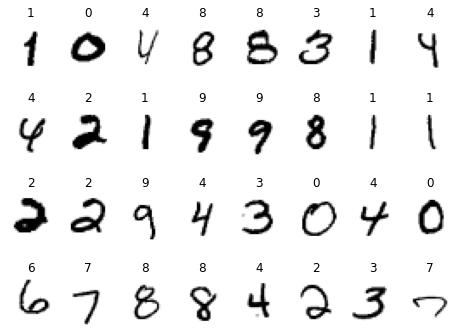

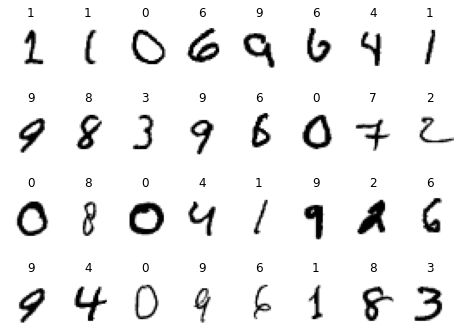

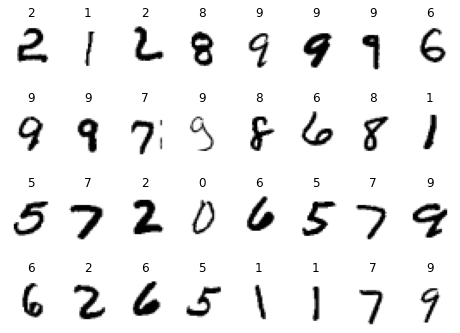

In [63]:
#Write your code here!
rnd_seed = np.random.default_rng()
sample_plotter(X_train, y_train, 4, 8, rnd_seed)
sample_plotter(X_valid, y_valid, 4, 8, rnd_seed)
sample_plotter(X_test, y_test, 4, 8, rnd_seed)

We're now ready to start developing our neural network. The first thing that we want to do is figure out an appropriate learning rate for our model - after all, we want to choose one that converges to a solution *and* is the least computationally expensive possible.

Let's start by setting up a keras *callback* [(click here for the documentation)](https://keras.io/api/callbacks/), a type of object that will allow us to change the learning rate after every iteration (i.e., after every batch of data). We will set up what is called an exponential learning rate (that is, the learning will increase by a factor of $k$ after each iteration). Expressed mathematically,
\begin{align}
\eta_{\scriptsize{t}} = \eta_{\scriptsize{0}} \, \cdot \, k^{\scriptsize{t}}
\end{align}
where $t$ is the current iteration. 

As a reminder, an epoch is an iteration through the entire training dataset, while a batch is an iteration through a predefined subset of . It's important to make this distinction, as ML algorithms are often trained in batches when dealing with large datasets, and we *normally* do not want to change the learning rate in between batches during model training. However, we will do so during this evaluation phase in order to determine an adequate learning rate.

We will therefore set a callback that will do two things after the end of each batch:

> 1) Keep a track of the losses <br> 2) Adjust the learning rate by multiplying it by a predefined factor

### **Q5) Set up an *Exponential_Learning_Rate* callback that, after each batch, logs the value of the loss function and learning rate, and then multiplies the learning rate by a factor of $k$** 

*Hint 1: Multiple backend options are available with Keras. We will be using tensorflow, but the code is thought to be written in such a way that a different backend **could** be used. `tf.keras.backend` has a `.backend()` method that allows you to check what backend is being used.*

*Hint 2: You should extend the `tf.keras.callbacks.Callback` class. (Confused about extending classes? [Here is a question on stack overflow](https://stackoverflow.com/questions/15526858/how-to-extend-a-class-in-python) that could provide some context) *

*Hint 3: The ExponentialLearningRate callback we will implement will need to take in the $k$ factor durint its initialization ([here's a quick overview](https://stackoverflow.com/questions/625083/what-do-init-and-self-do-in-python) on the __init__ contructor method and **self** arguments in classes, with a focus on python.). You will also need to save an empty list as an attribute for both the losses and the learning rates*

*Hint 4: Keras model optimizers have an attribute where the learning rate is stored: `model.optimizer.learning_rate`. In order to read the value, you will have to use the keras backend's `.get_value()` method with the model's learning rate as an argument*

*Hint 5: the on_train_batch_end method pass the `logs` argument into the function. You can access the loss function by using `logs['loss']`*

*Hint 6: In order to set the learning rate to a different value, you will have to depend on the keras backend's `.set_value()` method. This method takes in two arguments: the first is the value that will be set (e.g., the learning rate in the model's optimizer) and the value that it will be set to (e.g., the learning rate multiplied by the k factor).*

*Hint 7: Unlike in other documentations we've seen, `backend.get_value()` and `backend.set_value()` don't yet have their own page. However, [here is the link](https://www.tensorflow.org/guide/keras/custom_callback#learning_rate_scheduling) to an example where both methods are used in a learning rate scheduler.*

In [64]:
# We'll start by making it easier to access the keras backend. See hint #1 for
# more details
K = tf.keras.backend

# Use the .backend() method to determine what backend we're running 
K.backend()

'tensorflow'

In [65]:
# Remember that you can access the keras.backend using K, which we defined in 
# the code cell above!

class ExponentialLearningRate(tf.keras.callbacks.Callback): #define the ExponentialLearningRate class
    # Start 
    def __init__(self, factor):
        self.factor = K # set the factor
        self.losses = [] # initialize the losses list
        self.LRL = [] # initialize the learning rates list
        
    def on_batch_end(self, batch, logs):
        # Add the value of the learning rate to the list
        self.LRL.append(K.get_value(self.model.optimizer.learning_rate))

        # Add the value of the loss
        self.losses.append(logs['loss'])

        # Set the value of the 
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.K)

Now that we've defined out callback, we can go ahead and start thinking about our neural network. For consistency's sake, let's start by clearing the Keras backend and setting our random state.

In [66]:
# Run this cell
K.clear_session()
#np.random.seed(rnd_seed)
tf.random.set_seed(rnd_seed)

In [89]:
K.clear_session()
np.random.seed(rnd_seed)
tf.random.set_seed(rnd_seed)

TypeError: ignored

Let's make a simple neural network model using Keras. For this, we will rely on a [*Sequential model*](https://keras.io/guides/sequential_model/), since we will want all of the inputs of one layer to be fed into the next layer. We recommend using the architecture described in the diagram below, but feel free to define your own architecture!

<center><img width=60% src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/ETl6L_3bHENFt6ZDSgaCpIEBkg2cNPDGowc8u5V8Gxe7XQ?download=1'></center>

### **Q6) Write a sequential Keras model that will predict the digit class.**



*Hint 1: You can add the layers in the sequential model when initializing the model. It expects the layers in a list. Alternatively, you can add them one by one using the model's `.add()` method. [Check out the documentation here](https://keras.io/guides/sequential_model/#creating-a-sequential-model).*

*Hint 2: The input images should be flattened before feeding them into any densely connected layers. [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) for the flatten layer.*

*Hint 3: You want to use simple, densely connected layers for this exercise. [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) for the dense layer.*

*Hint 4: Using a dense layer with the number of units set to the number of classes (e.g., the number of different digits in the MNIST dataset: 10) using a softmax activation unit can be interpreted as a probability of the input belonging to a given class. [Here is the documentation](https://keras.io/api/layers/activations/#softmax-function) for the softmax activation function in Keras*

In [67]:
# Create your model! Feel free to use our outline, or make your own from scratch

model = keras.Sequential(
    [
        keras.layers.Flatten(),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

#tf.___.____.sequential([  # call the keras sequential model class
#                            ___,  # 1st Layer
#                            ___,  # 2nd Layer
#                            ___,  # 3rd Layer
#                            ___]) # 4th Layer

Now that we have a model defined, we need to run its `.compile()' method, in which we will give the model the following hyper-parameters:
> 1) Loss function will be set to sparse categorical cross entropy <br> 2) The optimizer will be set to Stochastic Gradient Descent with a learning rate of 1e-3 <br> 3) The model metrics will include the accuracy score 

### **Q7) Compile the model with the given hyperparameters (i.e., loss function, optimizer, and metrics) and instantiate the callback we defined previously using a $k$ factor of 1.005 (i.e., a 0.5% increase in learning rate per batch)**



*Hint 1: [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_crossentropy) for the sparse categorical cross entropy loss function in keras. You can simply reference the function using `loss='sparse_categorical_crossentropy'` when compiling.*

*Hint 2: [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) for the Stochastic Gradient Descent optimizer in keras*

*Hint 3: [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) for the accuracy score implementation in keras. Like with the sparse_categorical_cross_entropy loss, you can reference the accuracy score in the metrics list, e.g. by setting `metrics=['accuracy']` when compiling.*


In [70]:
model.compile(loss='sparse_categorical_crossentropy', # Set the loss function
              optimizer=keras.optimizers.SGD(learning_rate=0.005), # Set the optimizer and learning rate 
              metrics=['accuracy']) # Set the metrics

In [71]:
exponential_lr_callback = ExponentialLearningRate(factor=1.005)

Let's go ahead and train the compiled model for a single epoch. 


### **Q8) Fit the model for a single epoch, using the exponential learning rate callback we defined in the previous code cell. Then, plot the Loss vs Learning rate.**

*Hint 1: Just like in scikit-learn, the keras model includes a `.fit()` method to train the algorithm! [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).*

*Hint 2: After training, you can access the recorded losses and corresponding learning rates using the attributes we defined when we defined the class in Q5!*

In [90]:

history = model.fit(X_train, # set the training inputs
                    y_train, # set the training labels
                    epochs=1, # set the number of epochs
                    validation_data=(X_valid, y_valid), # set validation input/labels
                    callbacks=[exponential_lr_callback]) # Set the callback

TypeError: ignored

In [ ]:
# Plotting
fig, ax = plt.subplots()

ax.plot(___.___, # learning rates
        ___.___) # losses

# Define a tuple with (min_learning_rate, max_learn_rate)
x_limits = ( min(___.___), max(___.___) )

# Set the xscale to logarithmic 
ax.set_xscale('log')

# Draw a horizontal line at the minimum loss value
ax.hlines(min(____.___), #Find the minimum loss value to draw a horizontal line
          *x_limits, # the star unpacks x_limits to the expected num of args
          'g') 

# Set the limits for drawing the curves
ax.set_xlim(x_limits)
ax.set_ylim(0, ____) # use the initial loss as the top y boundary 

# Display gridlines to see better
ax.grid(which='both')

ax.set_xlabel("Learning rate")
ax.set_ylabel("Loss")

If you used the architecture we defined above with the learning rate we defined above, you should produce a graph that looks like this:
<center> <img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EUhU2fuy3K1Nm5iuia8ocF8BB2-jU_pAf6h5TA8MaIqrfw?download=1'> </center>

In this graph, you can see that the loss reaches a minimum at around 6e-1 and then begins to shoot up violently. Let's avoid that by using half that value (e.g., 3e-1). 

If you have a different curve, try setting your learning rate to half of the learning rate with the minimum loss! 😃


Now that we have an idea of what the learning rate should be, let's go ahead and start from scratch once more.

In [ ]:
# Run this cell - let's go back to a clean slate!
K.clear_session()
np.random.seed(rnd_seed)
tf.random.set_seed(rnd_seed)

We also want to instantiate the model again - the weights in our current model are quite bad and if we use it as is it won't be able to learn since the weights are too far away from the solution. There are other ways to do this, but since our model is quite simple it's worth it to just redefine and recompile it.

### **Q9) Redefine and re-compile the model with the learning rate you found in Q8.**

In [ ]:
# redefine the model
model = tf.keras.___.___([ # call the sequential model class
    tf.keras.layers.___(), # flatten the data
    tf.keras.layers.___(), # densely connected ReLU layer, 300 units
    tf.keras.layers.___(), # densely connected ReLU layer, 100 units
    tf.keras.layers.___())] # densely connected Softmax layer, 10 units


In [ ]:
____.compile(___=___, # Set the loss function
              ___=___.____.___(___=___), # Set the optimizer and learning rate
              ___=[___]) # Set the metrics

We're now going to set up a saving directory in case you want to try running the model with different learning rates or other hyper-parameters!

In [ ]:
#Change this number and rerun this cell whenever you want to change runs
run_index = 1 

run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))

print(run_logdir)

We'll also set up some additional callbacks.
> 1) An early stopping callback ([documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)). This callback will stop the training if no improvement is found after a `patience` number of epochs. <br> 2) A model checkpoint callback ([documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)). This callback will ensure that only the best version of the model is kept (in case your model's performance reaches a maximum and then deteriorates after a certain number of epochs) <br> 3) A tensorboard callback ([documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)). This callback will enable using Tensorboard to visualize learning curves, metrics, etc. Handy 🙌!

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

Let's go ahead and fit the model again!

### **Q10) Fit the updated model for 100 epochs** 

In [ ]:
history = model.fit(____, # inputs
                    ____, # labels
                    ____=___, #epochs
                    validation_data=(___, ___),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Finally, we need to evaluate the performance of our model. Go ahead and try it out on the test set!

### **Q11) Evaluate the model on the test set.**

*Hint 1: Keras models include an `evaluate()` method that takes in the test set inputs/labels. [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate).*

In [ ]:
# Rollback to best model, which was saved by the callback
model = tf.keras.models.load_model("my_mnist_model.h5") # rollback to best model

# Evaluate the model
model.____(____, ____)

Finally, we can use tensorboard to check out our model's performance! Note that the tensorboard extension was loaded in the notebook setup cell.

In [ ]:
%tensorboard --logdir=./my_mnist_logs --port=6006

An enthusiastic (albeit somewhat sick 😷) TA noted that during the development of the notebook the accuracy reached on the test dataset was 97.84%. Additionally, the tensorboard curves from the test run is given below:
<center> <img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EXPT4jVOfNZJpkSqD4wNktMByxa9LmH-uq0EU6PIaul27Q?download=1'> </center>